In [98]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt2   # why?
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import h5py

import fix_yahoo_finance as yf
# yf.pdr_override() # <== that's all it takes :-)

# Stock prediction using LSTM

Install the prerequisite packages above. We use Keras as the implementation tool.

Input parameters below.

In [7]:
stock_name = '^GSPC'
seq_len = 22                # the total length of a sample, x_t
d = 0.2                     # dropout rate
shape = [4, seq_len, 1]     # feature, window, output; 
                            # 4 stands for different numbers of the stock (open, high, low and adjacent)
neurons = [128, 128, 32, 1] # defines the network structure
epochs = 20                 # 300

### Step 1: Downlaod the data and preprocess
Data since 1950 to day

In [23]:
def get_stock_data(stock_name, normalize=True):
    start = datetime.datetime(1950, 1, 1)
    end = datetime.date.today()
    # df = web.DataReader(stock_name, "yahoo", start, end)
    df = web.get_data_yahoo(stock_name, start, end)
    df.drop(['Volume', 'Close'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df

In [32]:
df = get_stock_data(stock_name)
# print(df)
print(df.head())
print(df.tail())
print('\ndf shape is ', df.shape)

[*********************100%***********************]  1 of 1 downloaded
                Open      High       Low  Adj Close
Date                                               
1950-01-03  0.000000  0.000000  0.000000   0.000000
1950-01-04  0.000067  0.000067  0.000067   0.000067
1950-01-05  0.000095  0.000095  0.000095   0.000095
1950-01-06  0.000112  0.000112  0.000113   0.000112
1950-01-09  0.000147  0.000147  0.000148   0.000147
                Open      High       Low  Adj Close
Date                                               
2018-07-12  0.970501  0.974214  0.975325   0.973888
2018-07-13  0.975338  0.976073  0.978909   0.974946
2018-07-16  0.975489  0.974904  0.979508   0.973937
2018-07-17  0.972676  0.979455  0.978044   0.977831
2018-07-18  0.980397  0.980355  0.983918   0.979956

df shape is  (17247, 4)


#### Plot the data trend (normalized adjusted close price)

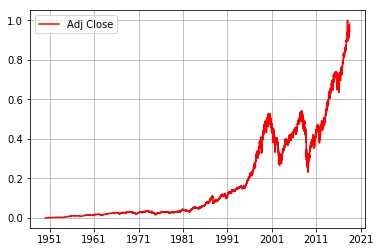

In [19]:
def plot_stock(data, field):
    plt.plot(data[field], color='red', label=field)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
plot_stock(df, 'Adj Close')

### Step 2: Prepare train/test data

In [47]:
def load_data(stock, seq_len):
    amount_of_feat = len(stock.columns)
    print('amount of feature is {}'.format(amount_of_feat))
    data = stock.values
    print('data shape is ', data.shape)

    result = []    
    for index in range(len(data) - seq_len):
        result.append(data[index : index + seq_len])
    result = np.array(result)
    
    print('result shape is ', result.shape)
    train_num = round(0.9 * result.shape[0])  # 90% split as train
    
    train_data = result[:int(train_num)]
    print('whole train_data shape is ', train_data.shape)
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:, -1]  # use the ajusted close price on the last day as target
    print('\nx_train shape: ', x_train.shape)
    print('y_train shape ', y_train.shape)
    
    x_test = result[int(train_num):, :-1]
    y_test = result[int(train_num):, -1][:, -1]
    print('x_test shape: ', x_test.shape)
    print('y_test shape ', y_test.shape)
    
    assert x_train.shape[2] == amount_of_feat
    return [x_train, y_train, x_test, y_test]

x_train, y_train, x_test, y_test = load_data(df, seq_len)

amount of feature is 4
data shape is  (17247, 4)
result shape is  (17225, 22, 4)
whole train_data shape is  (15502, 22, 4)

x_train shape:  (15502, 21, 4)
y_train shape  (15502,)
x_test shape:  (1723, 21, 4)
y_test shape  (1723,)


### Step 3: Create model/network withe Keras

For documents of LSTM in Keras, see [here](https://keras.io/layers/recurrent/#lstm).
The first arugment is `units`, which indicates the dimensionality of the output space.

In [58]:
# shape = [4, seq_len, 1]   
# neurons = [128, 128, 32, 1]

def build_model(shape, neurons):
    model = Sequential()
    model.add(LSTM(neurons[0], input_shape=(shape[1]-1, shape[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(neurons[1], input_shape=(shape[1]-1, shape[0]), return_sequences=False))
    model.add(Dropout(d))
    
    model.add(Dense(neurons[2], kernel_initializer="uniform", activation='relu'))        
    model.add(Dense(neurons[3], kernel_initializer="uniform", activation='linear'))
    
    print('Network is:')
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
    return model

In [59]:
model = build_model(shape, neurons)

Network is:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 21, 128)           68096     
_________________________________________________________________
dropout_8 (Dropout)          (None, 21, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
__________________________________________________________

Question: think about how the number of parameters are acquired. 
Say 4128 in dense_layer. (4128 = 32 x 128 + 32)

### Step 4: train the model

TODO: show part of the epoch.

Question: **students! why the acc is zero?**

In [60]:
model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 13951 samples, validate on 1551 samples
Epoch 1/300
13951/13951 [==============================] - 8s 593us/step - loss: 0.0101 - acc: 0.0000e+00 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 2/300
13951/13951 [==============================] - 8s 563us/step - loss: 3.7416e-04 - acc: 0.0000e+00 - val_loss: 6.3133e-04 - val_acc: 0.0000e+00
Epoch 3/300
13951/13951 [==============================] - 8s 552us/step - loss: 1.4271e-04 - acc: 0.0000e+00 - val_loss: 4.0404e-04 - val_acc: 0.0000e+00
Epoch 4/300
13951/13951 [==============================] - 8s 579us/step - loss: 1.1729e-04 - acc: 0.0000e+00 - val_loss: 2.5198e-04 - val_acc: 0.0000e+00
Epoch 5/300
13951/13951 [==============================] - 8s 594us/step - loss: 1.1718e-04 - acc: 0.0000e+00 - val_loss: 3.2909e-04 - val_acc: 0.0000e+00
Epoch 6/300
13951/13951 [==============================] - 9s 613us/step - loss: 9.9163e-05 - acc: 0.0000e+00 - val_loss: 1.8798e-04 - val_acc: 0.0000e+00
Epoch 7/300
13951/13951 [====

13951/13951 [==============================] - 8s 572us/step - loss: 4.6309e-05 - acc: 0.0000e+00 - val_loss: 8.0776e-05 - val_acc: 0.0000e+00
Epoch 106/300
13951/13951 [==============================] - 8s 599us/step - loss: 4.4195e-05 - acc: 0.0000e+00 - val_loss: 9.4711e-05 - val_acc: 0.0000e+00
Epoch 107/300
13951/13951 [==============================] - 8s 561us/step - loss: 4.8601e-05 - acc: 0.0000e+00 - val_loss: 8.9379e-05 - val_acc: 0.0000e+00
Epoch 108/300
13951/13951 [==============================] - 8s 574us/step - loss: 4.3924e-05 - acc: 0.0000e+00 - val_loss: 2.3463e-04 - val_acc: 0.0000e+00
Epoch 109/300
13951/13951 [==============================] - 8s 556us/step - loss: 5.0231e-05 - acc: 0.0000e+00 - val_loss: 2.9823e-04 - val_acc: 0.0000e+00
Epoch 110/300
13951/13951 [==============================] - 8s 549us/step - loss: 4.4883e-05 - acc: 0.0000e+00 - val_loss: 7.9925e-05 - val_acc: 0.0000e+00
Epoch 111/300
13951/13951 [==============================] - 8s 561us/st

KeyboardInterrupt: 

### Step 5: Evaluate the model

In [65]:
def model_score(model, x_train, y_train, x_test, y_test):
    score_train = model.evaluate(x_train, y_train, verbose=0)
    score_test = model.evaluate(x_test, y_test, verbose=0)
    
    print('train score is {:.5f}; test score (MSE) is {:.5f}'.format(score_train[0], score_test[0]))
    return score_train[0], score_test[0]

train_score, test_score = model_score(model, x_train, y_train, x_test, y_test)

train score is 0.00002; test score (MSE) is 0.00016


### Step 6: Visualize predictions and save model

In [66]:
def percentage_difference(model, x_test, y_test):
    
    percentage_diff=[]
    p = model.predict(X_test)
    for u in range(len(y_test)):  # for each data index in test data
        pr = p[u][0]              # pr = prediction on day u
        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [67]:
p = percentage_difference(model, x_test, y_test)

In [93]:
def denormalize(df, normalized_value):
    
    df = df['Adj Close'].values.reshape(-1, 1)  
    # return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(df)
    
    # print('normalized value shape: ', normalized_value.shape)
    normalized_value = normalized_value.reshape(-1,1)  # TODO: not sure why; but necessary; otherwise bug occurs
    # print('normalized value shape, after reshape: ', normalized_value.shape)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [96]:
def plot_result(stock_name, df, normalized_p, normalized_y_test):
    new_p = denormalize(df, normalized_p)
    new_y_test = denormalize(df, normalized_y_test)
    
    plt.plot(new_p, color='red', label='Prediction')
    plt.plot(new_y_test, color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('The test result for {}'.format(stock_name))
    plt.xlabel('Days')
    plt.ylabel('Adjusted Close')
    plt.show()

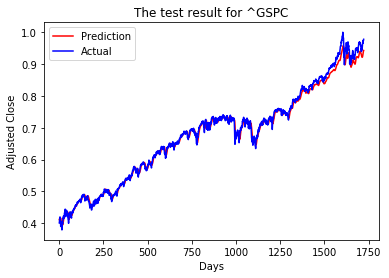

In [99]:
plot_result(stock_name, df, p, y_test)

In [119]:
file_name = 'LSTM_stock_prediction_{}.h5'.format(str(datetime.date.today()))
model.save(file_name)

We can see the model did a quite good job in predicting the future stock trend!

## Time to get your hands dirty

- Draw the network flow
- Find the optimal hyperparameters to have the lowest MSE score!
    - number of neurons
    - the length of window
    - dropout rate
    - network structure
    - ...

You may refer to this [link](https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/blob/master/Old%20version/LSTM_Stock_prediction_20170508.ipynb) for reference.